# Project September (bonus) — Learnable Quantum Kernel SVM

This notebook explores a **parameterized quantum kernel** for SVM,  
where circuit parameters are optimized to adapt to the data.  


# Learnable Quantum Kernel SVM

This section implements:
- A **baseline quantum kernel SVM** using the inversion routine.
- A **learnable quantum kernel** with tunable parameters optimized via Bayesian optimization.
- Comparison with a **classical RBF SVM**.
- Fast decision boundary plotting for all models.


Optimizing kernel parameters on subsample...


Best alignment (subsampled): 0.3093252008565123
Best params (first 10): [3.14159265 1.6902047 ]
Baseline Quantum Kernel SVM
Train accuracy: 0.875
Test accuracy : 0.95

Learnable Quantum Kernel SVM
Train accuracy: 0.985
Test accuracy : 1.0

Classical RBF SVM
Train accuracy: 0.98
Test accuracy : 0.975


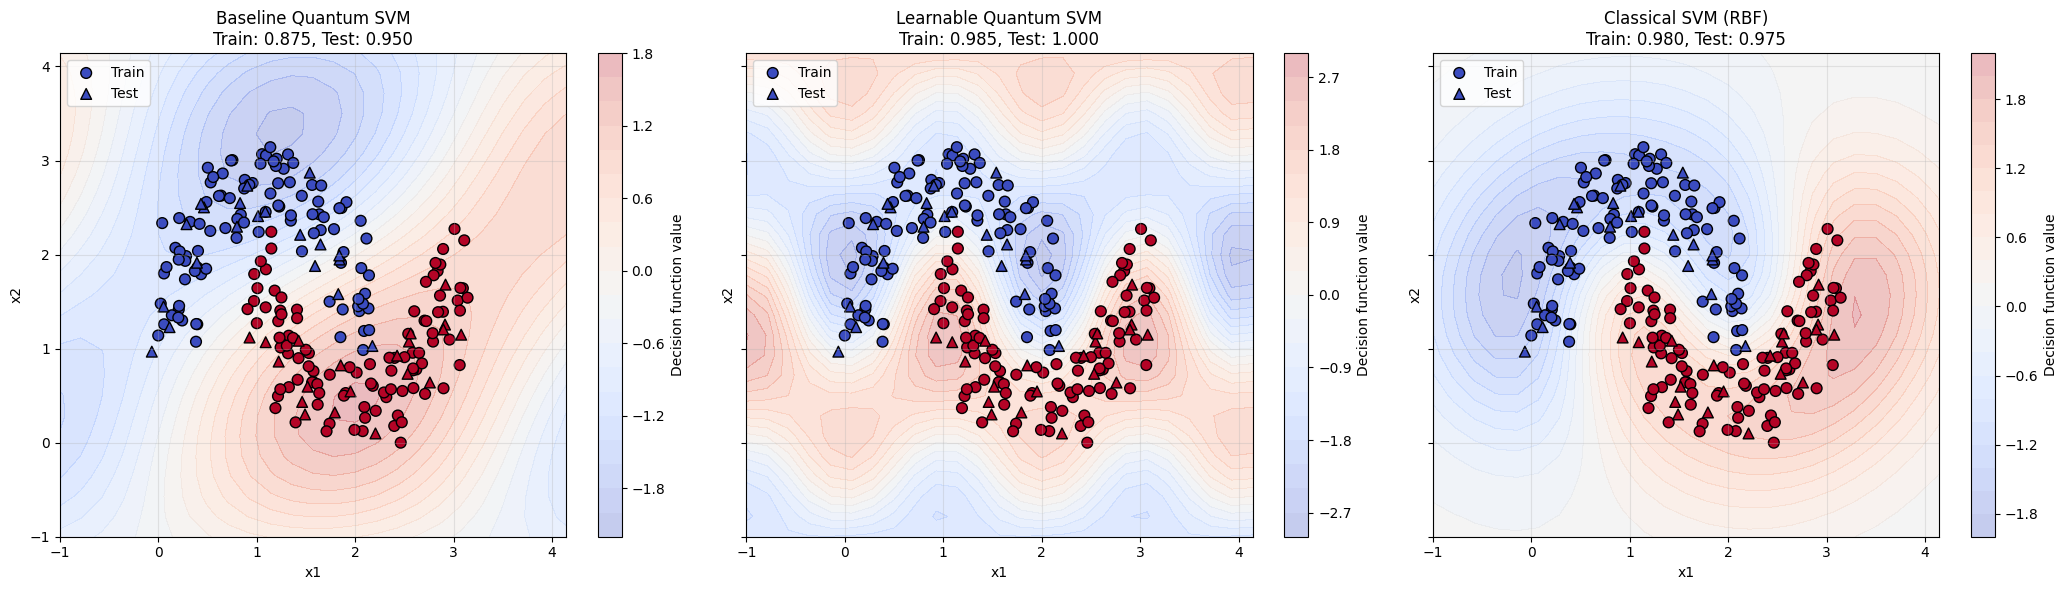

In [39]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.utils import resample
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from joblib import Parallel, delayed
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# --- Load Data ---
def load_tab_file(path):
    """Load tab-separated file into DataFrame."""
    return pd.read_csv(path, sep="\t", header=None)

# Data paths
p_class1_train = Path("data/class1_data_train.dat")
p_class1_test  = Path("data/class1_data_test.dat")
p_class2_train = Path("data/class2_data_train.dat")
p_class2_test  = Path("data/class2_data_test.dat")

# Load datasets
df1_train = load_tab_file(p_class1_train)
df1_test  = load_tab_file(p_class1_test)
df2_train = load_tab_file(p_class2_train)
df2_test  = load_tab_file(p_class2_test)

# Add labels
df1_train['y'] = 0
df2_train['y'] = 1
df1_test['y']  = 0
df2_test['y']  = 1

# Combine
df_train = pd.concat([df1_train, df2_train], ignore_index=True)
df_test  = pd.concat([df1_test, df2_test], ignore_index=True)

X_train = df_train.drop(columns=["y"]).values
y_train = df_train["y"].values
X_test  = df_test.drop(columns=["y"]).values
y_test  = df_test["y"].values

# Scale features to [0, pi] for RY rotations
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# --- Baseline Quantum Kernel ---
def encode_data(x):
    """Encode classical vector into quantum circuit with RY rotations."""
    qc = QuantumCircuit(len(x))
    for i, val in enumerate(x):
        qc.ry(val, i)
    return qc

def quantum_kernel_inversion(x, y):
    """Compute quantum kernel as probability to return to |0>^n."""
    Ux = encode_data(x)
    Uy = encode_data(y)
    circ = Ux.inverse().compose(Uy)
    state = Statevector.from_instruction(circ)
    return np.abs(state.data[0])**2

def build_kernel_matrix_baseline(XA, XB, n_jobs=-1):
    """Build full kernel matrix for baseline quantum kernel."""
    def compute_row(i):
        return [quantum_kernel_inversion(XA[i], XB[j]) for j in range(len(XB))]
    K = Parallel(n_jobs=n_jobs)(delayed(compute_row)(i) for i in range(len(XA)))
    return np.array(K)

# --- Learnable Quantum Kernel ---
def quantum_kernel_param(x, y, theta):
    """Parameterized quantum kernel with RY rotations and CZ entanglement."""
    Ux = QuantumCircuit(len(x))
    Uy = QuantumCircuit(len(y))
    for i, val in enumerate(x):
        Ux.ry(theta[i] * val, i)
    for i in range(len(x)-1):
        Ux.cz(i, i+1)
    for i, val in enumerate(y):
        Uy.ry(theta[i] * val, i)
    for i in range(len(y)-1):
        Uy.cz(i, i+1)
    circ = Ux.inverse().compose(Uy)
    state = Statevector.from_instruction(circ)
    return np.abs(state.data[0])**2

def build_kernel_matrix_learnable(XA, XB, theta, n_jobs=-1):
    """Build full kernel matrix for learnable quantum kernel."""
    def compute_row(i):
        return [quantum_kernel_param(XA[i], XB[j], theta) for j in range(len(XB))]
    K = Parallel(n_jobs=n_jobs)(delayed(compute_row)(i) for i in range(len(XA)))
    return np.array(K)

# --- Kernel-Target Alignment ---
def kernel_target_alignment(K, y):
    """Compute kernel-target alignment score."""
    y_pm = (2*y - 1).astype(float)
    Y = np.outer(y_pm, y_pm)
    num = np.sum(K*Y)
    den = np.sqrt(np.sum(K*K) * np.sum(Y*Y))
    return num/den

# --- Bayesian Optimization (subsampled for speed) ---
n_features = X_train.shape[1]
space = [Real(0.0, np.pi, name=f"theta_{i}") for i in range(n_features)]
subsample_size = min(50, len(X_train_scaled))

@use_named_args(space)
def objective_subsampled(**params_dict):
    theta = np.array([params_dict[f"theta_{i}"] for i in range(n_features)])
    X_sub, y_sub = resample(X_train_scaled, y_train, n_samples=subsample_size, random_state=42)
    K_sub = build_kernel_matrix_learnable(X_sub, X_sub, theta)
    return -kernel_target_alignment(K_sub, y_sub)

print("Optimizing kernel parameters on subsample...")
res_sub = gp_minimize(objective_subsampled, space, n_calls=25, random_state=42)

best_params = np.array(res_sub.x)
best_align = -res_sub.fun
print("Best alignment (subsampled):", best_align)
print("Best params (first 10):", best_params[:min(10, n_features)])

# --- Train SVMs ---
# Baseline Quantum Kernel
K_train_base = build_kernel_matrix_baseline(X_train_scaled, X_train_scaled)
K_test_base  = build_kernel_matrix_baseline(X_test_scaled, X_train_scaled)

qsvc_base = SVC(kernel="precomputed")
qsvc_base.fit(K_train_base, y_train)
train_acc_base = accuracy_score(y_train, qsvc_base.predict(K_train_base))
test_acc_base  = accuracy_score(y_test, qsvc_base.predict(K_test_base))

# Learnable Quantum Kernel
K_train_best = build_kernel_matrix_learnable(X_train_scaled, X_train_scaled, best_params)
K_test_best  = build_kernel_matrix_learnable(X_test_scaled, X_train_scaled, best_params)

qsvc_best = SVC(kernel="precomputed")
qsvc_best.fit(K_train_best, y_train)
train_acc_best = accuracy_score(y_train, qsvc_best.predict(K_train_best))
test_acc_best  = accuracy_score(y_test, qsvc_best.predict(K_test_best))

# Classical RBF SVM
svc_rbf = SVC(kernel="rbf")
svc_rbf.fit(X_train_scaled, y_train)
train_acc_rbf = accuracy_score(y_train, svc_rbf.predict(X_train_scaled))
test_acc_rbf  = accuracy_score(y_test, svc_rbf.predict(X_test_scaled))

# --- Print evaluation results ---
print("Baseline Quantum Kernel SVM")
print("Train accuracy:", train_acc_base)
print("Test accuracy :", test_acc_base)

print("\nLearnable Quantum Kernel SVM")
print("Train accuracy:", train_acc_best)
print("Test accuracy :", test_acc_best)

print("\nClassical RBF SVM")
print("Train accuracy:", train_acc_rbf)
print("Test accuracy :", test_acc_rbf)

# --- Plotting function (parallelized) ---
def fast_plot_decision_boundary_parallel(X_train, y_train, X_test, y_test, clf, theta=None, title="", grid_res=25, n_jobs=-1):
    """Plot decision boundary using PCA if necessary, supports quantum precomputed kernels."""
    if X_train.shape[1] > 2:
        pca = PCA(n_components=2, random_state=42)
        X_train_2d = pca.fit_transform(X_train)
        X_test_2d  = pca.transform(X_test)
    else:
        X_train_2d, X_test_2d = X_train, X_test

    x_min, x_max = X_train_2d[:,0].min()-1, X_train_2d[:,0].max()+1
    y_min, y_max = X_train_2d[:,1].min()-1, X_train_2d[:,1].max()+1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_res),
                         np.linspace(y_min, y_max, grid_res))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    if X_train.shape[1] > 2:
        grid_points_full = pca.inverse_transform(grid_points)
    else:
        grid_points_full = grid_points

    if isinstance(clf, SVC) and clf.kernel == 'precomputed':
        def compute_row(i):
            return [quantum_kernel_param(grid_points_full[i], X_train[j],
                                         theta if theta is not None else np.ones(X_train.shape[1]))
                    for j in range(len(X_train))]
        K_grid = Parallel(n_jobs=n_jobs)(delayed(compute_row)(i) for i in range(len(grid_points_full)))
        K_grid = np.array(K_grid)
        Z = clf.decision_function(K_grid)
    else:
        Z = clf.decision_function(grid_points_full)

    Z = Z.reshape(xx.shape)
    contour = plt.contourf(xx, yy, Z, levels=20, cmap=plt.cm.coolwarm, alpha=0.3)
    plt.scatter(X_train_2d[:,0], X_train_2d[:,1], c=y_train, cmap=plt.cm.coolwarm,
                s=60, edgecolor='k', marker='o', label='Train')
    plt.scatter(X_test_2d[:,0], X_test_2d[:,1], c=y_test, cmap=plt.cm.coolwarm,
                s=60, edgecolor='k', marker='^', label='Test')
    plt.xlabel("PC1" if X_train.shape[1]>2 else "x1")
    plt.ylabel("PC2" if X_train.shape[1]>2 else "x2")
    plt.title(title)
    plt.grid(alpha=0.3)
    cbar = plt.colorbar(contour)
    cbar.set_label('Decision function value')
    plt.legend(loc='upper left')

# --- Plot all models ---
fig, axes = plt.subplots(1, 3, figsize=(21,6), sharex=True, sharey=True)

plt.sca(axes[0])
fast_plot_decision_boundary_parallel(X_train_scaled, y_train, X_test_scaled, y_test,
                                    qsvc_base,
                                    title=f"Baseline Quantum SVM\nTrain: {train_acc_base:.3f}, Test: {test_acc_base:.3f}",
                                    n_jobs=-1)

plt.sca(axes[1])
fast_plot_decision_boundary_parallel(X_train_scaled, y_train, X_test_scaled, y_test,
                                    qsvc_best, theta=best_params,
                                    title=f"Learnable Quantum SVM\nTrain: {train_acc_best:.3f}, Test: {test_acc_best:.3f}",
                                    n_jobs=-1)

plt.sca(axes[2])
fast_plot_decision_boundary_parallel(X_train_scaled, y_train, X_test_scaled, y_test,
                                    svc_rbf,
                                    title=f"Classical SVM (RBF)\nTrain: {train_acc_rbf:.3f}, Test: {test_acc_rbf:.3f}")

plt.tight_layout()
plt.show()
